In [3]:
from sklearn.datasets import fetch_mldata

In [4]:
mnist = fetch_mldata('MNIST original', data_home='datasets')

In [5]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [6]:
print(mnist['DESCR'])
print(mnist['data'])
print(mnist['target'])

mldata.org dataset: mnist-original
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
[ 0.  0.  0. ...,  9.  9.  9.]


In [7]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


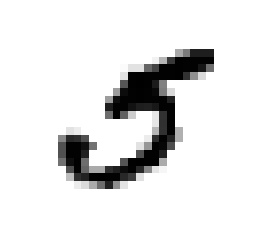

5.0


In [88]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def display_number(digit):
    image = digit.reshape(28, 28)
    plt.imshow(
        image,
        cmap=matplotlib.cm.binary,
        interpolation='nearest',
    )
    plt.axis('off')
    plt.show()

display_number(X[36000])
print(y[36000])

In [56]:
training_idx = 60000
X_train, X_test = X[:training_idx], X[training_idx:]
y_train, y_test = y[:training_idx], y[training_idx:]

In [70]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier

In [11]:
# Create an array of booleans (True or False) where the label is 5
y_train_5 = y_train == 5
y_test_5 = y_test == 5

## Stochastic Gradient Descent
Can handle very large datasets efficiently.
This is in part because SGD deals with training instances 
independently, one at a time (which also makes SGD well suited for
online learning).

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([False], dtype=bool)

## Performance Measures
Evaluating a classifier is often significantly trickier than 
evaluating a regressor.

In [13]:
# Cross-validation
from helpers.cross_validation import cross_validate
cross_validate({
    'data': X_train,
    'labels': y_train_5,
    'model': sgd_clf,
})

0.94885
0.95695
0.94885


### Confusion Matrix
Accuracy is generally not the preferred performance measure for
classifiers, especially when you are dealing with skewed datasets.

The general idea is to count the number of times instances of class A
are classified as class B.

In [14]:
from sklearn.model_selection import cross_val_predict

# You get a "clean" prediction for each instance in the training set.
# Clean meaning that the prediction is made by a model that never
# saw the data during training.
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix

# Each row represents an actual class, while each column represents
# a predicted class.
# [true negatives, false positives]
# [false negatives, true positives]
confusion_matrix(y_train_5, y_train_pred)

array([[53933,   646],
       [ 2261,  3160]])

### Precision
Of all examples of a particular class detected, how many of them
were correctly detected.

`precision = true positives / (true positives + false positives)`

When the classifier claims a number is a 5, it is correct only 82% of
the time.

### Recall (aka sensitivity or true positive rate, TPR)
Of all examples of a particular class, how many of them were
correctly detected.

`recall = true positives / (true positives + false negatives)`

It only detects 75% of the 5s.

In [15]:
from sklearn.metrics import precision_score, recall_score

print(
    precision_score(y_train_5, y_train_pred),
    recall_score(y_train_5, y_train_pred),
)

0.830267997898 0.58291828076


### F1 score
It is often convenient to combine precision and recall into a single
metric called the F1 score.

The F1 score is the harmonic mean of precision and recall.

Whereas the regular mean treats all values equally, the harmonic mean
gives much more weight to low values. As a result, the classifier
will only get a high F1 score if both precision and recall are high.

`F1 = 2 / ((1 / precision) + (1 / recall))`

`F1 = 2 * ((precision * recall) / (precision + recall))`

`F1 = TP / (TP + ((FN + FP) / 2)`

In [16]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.68494635309418017

The F1 score favors classifiers that have similar precision and 
recall.

This is not always what you want: in some context you mostly care 
about precision, and in other contexts you care about recall.

For example, training a classifier to detect videos that are safe for
kids you want high precision.

Training a classifier to detect shoplifters, you want high recall
since it is fine with only 30% precision as long as 99% of shoplifters
are caught with 99% recall.

### Precision/Recall Tradeoff
For each instance, it computes a score based on a *decision function*,
and if the score is greater than a threshold, it assigns the instance
to the positive class, or else it assigns it to the negative class.

Scikit-Learn does not let you set the threshold directly, but it does
give you access to the decision scores that it uses to make 
predictions.

Instead of calling `predict()`, call `decision_function()`.

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

[-62329.35667331]


array([False], dtype=bool)

In [18]:
threshold = 200000
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([False], dtype=bool)

How can you decide which threshold to use?

For this, you wil first need to get the scores of all the instances
in the training set using the `cross_val_predict()` function again,
but this time specify that you want it to return decision scores
instead of predictions:

In [19]:
y_scores = cross_val_predict(
    sgd_clf,
    X_train,
    y_train_5,
    cv=3,
    method='decision_function',
)

With these scores, you can compute precision and recall for all
possible thresholds using the `precision_recall_curve()` function:

In [20]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(
    y_train_5,
    y_scores,
)

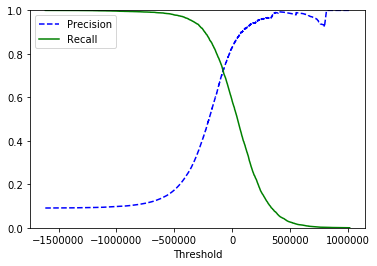

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [22]:
y_train_pred_90 = y_scores > 70000

In [23]:
precision_score(y_train_5, y_train_pred_90)

0.89440993788819878

In [24]:
# If someone asks to reach 99% precision, ask at what recall?
recall_score(y_train_5, y_train_pred_90) # 4,087 / 5,421.0

0.45157719977863864

# The ROC Curve
The *receiver operating characteristic* (ROC) curve is another
common tool used with binary classifiers.

If it is very similar to the precision/recall curve, but instead of
plotting precision versus recall, the ROC curve plots the
*true positive rate* (another name for recall) against the
*false positive rate*.

The FPR (false positive rate) is the ratio of negative instances
that are incorrectly classified as positive. It is equal to
1 minus the *true negative rate*, which is the ratio of negative
instances that are correctly classified as negative.

The TNR (true negative rate) is also called specificity.
Hence, the ROC curve plots sensitivity (recall) versus 1 -
*specificity*.

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

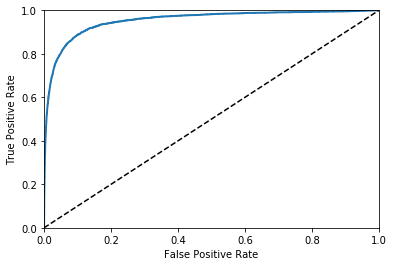

In [26]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [27]:
# Area under the curve (AUC)

# A perfect classifier will have a ROC AUC equal to 1
# A random classifier will have a ROC AUC equal to 0.5

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.95363454193496733

Since the ROC curve is so similar to the precision/recall (or PR)
curve, you may wonder how to decide which one to use.

As a rule of thumb, you should prefer the PR curve whenever the 
positive class is rare or when you care more about the false
positives than the false negatives, and the ROC curve otherwise.

Classifiers generally have `decision_function()` or
`predict_proba()` (returns an array containing a row per instance
and a column per class, each containing the probability that the
given instance belongs to the given class).

In [28]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(
    forest_clf,
    X_train,
    y_train_5,
    cv=3,
    method='predict_proba',
)

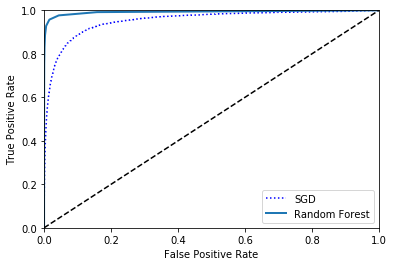

In [29]:
# To plot a ROC curve, you need scores, not probabilities.
# Use the positive class's probability as the score.
y_scores_forest = y_probas_forest[:, 1] # Select all rows, 2nd column
fpr_forest, tpr_forest, thresholds_forest = roc_curve(
    y_train_5,
    y_scores_forest,
)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [30]:
roc_auc_score(y_train_5, y_scores_forest)

0.99243660684557988

In [31]:
precision_score(y_train_5, y_scores_forest > 0.5)

0.9844604946377763

In [32]:
recall_score(y_train_5, y_scores_forest > 0.5)

0.82973621103117501

# Multi-class Classification
Aka multinomial classifiers. Random Forest and Naive Bayes classifiers
can handle multiple objects directly. However, SVM and linear
classifiers can only do binary classification.

One-vs-all aka one-vs-the-rest: train N binary classifiers, then
choose the highest output score.

One-vs-one: train binary classifier for every pair of classes; e.g.
0 vs 1, 0 vs 2, 0 vs 3, 0 vs n.
Main advantage is each classifier only needs to be trained on the part
of the training set for the two classes that it must distinguish.

SVMs scale poorly with the size of the training set, so for these
algorithms OvO is preferred since it is faster to train many
classifiers on small training sets than training few classifiers
on large training sets.

OvA is preferred for most binary classification algorithms.

In [33]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [34]:
sgd_clf.predict([some_digit])

array([ 0.])

In [35]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[  -8693.11630224, -623775.98365225, -245087.81703507,
        -238851.7990977 , -293393.01449948,  -62329.35667331,
        -727882.73387282, -357736.86102424, -743055.56060015,
        -466393.31665166]])

In [36]:
np.argmax(some_digit_scores)

0

In [37]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [38]:
sgd_clf.classes_[np.argmax(some_digit_scores)]

0.0

In [39]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [40]:
len(ovo_clf.estimators_)

45

In [41]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [42]:
forest_clf.predict([some_digit])

array([ 5.])

In [43]:
list(forest_clf.predict_proba([some_digit])[0])

[0.0,
 0.0,
 0.0,
 0.20000000000000001,
 0.0,
 0.80000000000000004,
 0.0,
 0.0,
 0.0,
 0.0]

In [44]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    sgd_clf,
    X_train,
    y_train,
    cv=3,
    scoring='accuracy',
)
list(scores)

[0.86797640471905624, 0.86414320716035797, 0.86983047457118567]

In [45]:
# If you randomly classified each digit, you would have 10% accuracy.
# So +80% accuracy isn't so bad.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
scores2 = cross_val_score(
    sgd_clf,
    X_train_scaled,
    y_train,
    cv=3,
    scoring='accuracy',
)
list(scores2)

[0.91106778644271147, 0.90594529726486328, 0.91093664049607437]

# Error Analysis

Analyze the types of errors it makes. First, look at the confusion
matrix.

In [46]:
y_train_pred = cross_val_predict(
    sgd_clf,
    X_train_scaled,
    y_train,
    cv=3,
)

In [47]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5720,    2,   23,    8,   11,   57,   47,    9,   40,    6],
       [   1, 6483,   44,   30,    6,   47,    7,   12,  104,    8],
       [  57,   44, 5325,   98,   86,   26,   94,   59,  156,   13],
       [  46,   43,  141, 5349,    4,  219,   37,   57,  135,  100],
       [  19,   30,   33,   10, 5386,    9,   61,   27,   79,  188],
       [  70,   45,   37,  193,   75, 4593,  108,   29,  183,   88],
       [  32,   26,   48,    1,   41,   93, 5620,    7,   49,    1],
       [  19,   25,   65,   28,   63,   13,    7, 5837,   13,  195],
       [  51,  162,   70,  171,   12,  154,   54,   21, 5007,  149],
       [  39,   41,   26,   91,  167,   34,    3,  236,   73, 5239]])

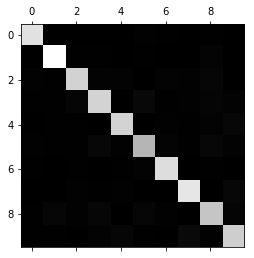

In [48]:
# Image representation of the confusion matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Focus the plot on the errors
Divide each value in the confusion matrix by the number of images
in the corresponding class, so you can compare error rates instead of
absolute number of errors.

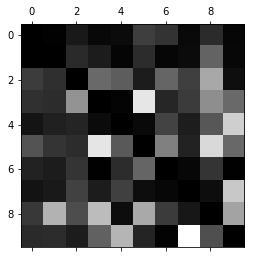

In [49]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [50]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)  
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

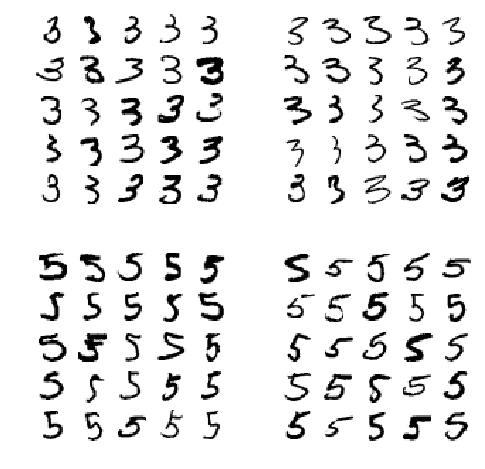

In [51]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224)
plot_digits(X_bb[:25], images_per_row=5)

One way to reduce the 3/5 confusion would be to preprocess the images
to ensure that they are well centered and not too rotated.

# Multilabel Classification
A classification system that outputs multiple binary labels is called
a *multilabel classification system*.

Image with 3 people; Alice is in it, Bob is not in it, and Charlie is
`([1, 0, 1])`.

In [93]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

In [50]:
# Illustration purposes

y_train_large = y_train >= 7
y_train_odd = y_train % 2 == 1
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

There are many ways to evaluate a multilabel classifier.
One approach is to measure the F1 score for each individual label.
Then compute the average score. The following computes the average
F1 score across all labels:

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)

This assumes that all labels are equally important.
If you have more images of alice than Bob, you want to give more
weight to the classifier's score on pictures of alice.

Give each label a weight equal to its support
(e.g. the number of instances with that target label).
Set `average='weighted'` in the `f1_score` method.

In [ ]:
f1_score(y_train, y_train_knn_pred, average='macro')

# Multioutput Classification
Aka *multioutput-multiclass classificatiom*

Multilabel classification where each label can be multiclass.
Example, the age of people in a group photo.

In [80]:
import numpy.random as rnd

# Input noisy image, output clean image
noise_train = rnd.randint(0, 100, (len(X_train), 784))
noise_test = rnd.randint(0, 100, (len(X_test), 784))
X_train_mod = X_train + noise_train
X_test_mod = X_test + noise_test
y_train_mod = X_train
y_test_mod = X_test

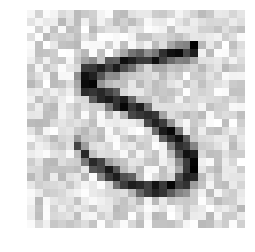

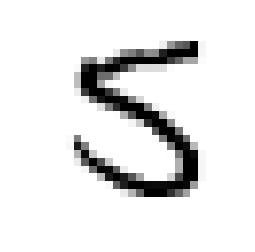

In [90]:
display_number(X_train_mod[10000])
display_number(y_train_mod[10000])

In [94]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

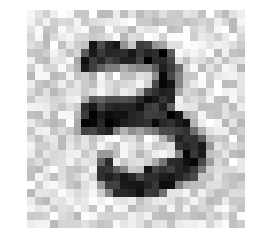

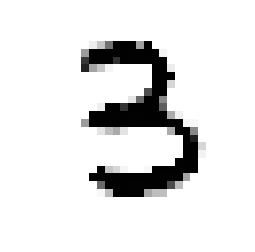

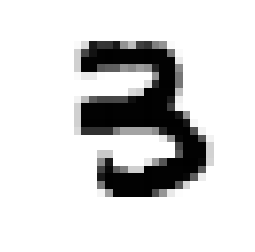

3.0


In [126]:
idx = rnd.randint(0, len(X_test_mod) - 1)

actual_digit = y_test_mod[idx]
test_noisey_digit = X_test_mod[idx]
clean_digit = knn_clf.predict([test_noisey_digit])
                               
display_number(test_noisey_digit)
display_number(clean_digit)
display_number(actual_digit)
                               
print(y_test[idx])